In [1]:
#Load required modules
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from monai import transforms
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import json
import sys
sys.path.append(os.getcwd())

from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from networks.SiameseNetwork import SiameseNetwork

from pytorch_metric_learning.losses import NTXentLoss
from dataset.nih_chest_xray_cl import NIHXRayDataset
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist



2023-10-12 15:31:43.499157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:31:44.247903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Define network
model = SiameseNetwork()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
exp = 'siamese_network_try/'
model_dir = '/mnt/sds/sd20i001/salman/ckpt/Diffusion-2D-NIHXray/'
model.load_state_dict(torch.load(model_dir+exp+'model_best'))
#model.eval()



/home/salman/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/salman/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [3]:
#Load Training validation and training
training_samples = 10000
downsample = 2
batch_size = 200
data_dir = '/mnt/sds/sd20i001/salman/data/NIHXRay'
train_data = NIHXRayDataset(root_dir= data_dir, split = 'train', training_samples = training_samples, donwsample = downsample)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

validation_samples = 10000
val_data = NIHXRayDataset(root_dir= data_dir, split = 'val', validation_samples = validation_samples, donwsample = downsample)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)


In [5]:

#Load synthetic data
data_synth_dir = '/mnt/sds/sd20i001/salman/results/Diffusion-2D-NIHXray/'
exp = 'LDM_exp_14c/'
synth_data = np.load(data_synth_dir + exp + 'synthesized_samples_949.npz')['synth']
#normalize synthetic data
for ii in range(synth_data.shape[0]):
    synth_data[ii,:] = (synth_data[ii,:]-synth_data[ii,:].min())/(synth_data[ii,:].max()-synth_data[ii,:].min()+1e-4)
synth_data = synth_data.astype(np.float32)

In [16]:

print(synth_data.dtype)

float32


In [6]:
#Load training and validation embeddings
train_train_diff = []; train_synth_diff = [];train_val_diff = []
synth_emb = []; val_emb = [];train_emb = []
with torch.no_grad():
    #progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar = tqdm(enumerate(zip(train_loader,val_loader)), total=len(train_loader), ncols=110)
    progress_bar.set_description("Training and validation data")   
    for step, batch in progress_bar:
    #for val_step, batch in enumerate(train_loader):  
        #val = next(iter(val_loader))['data'].to(device)
        train = batch[0]['data'].to(device)
        val = batch[1]['data'].to(device)
        output_comb = model.forward(train, val)
        train_emb.append(output_comb[1].cpu().numpy()) 
        val_emb.append(output_comb[2].cpu().numpy()) 
        # for ii in range(val_data.__len__()):
        #     #print(ii)
        #     syn = torch.from_numpy(synth_data[ii,:]).to(device).unsqueeze(dim=0)
        #     val = val_data.__getitem__(ii)['data'].to(device).unsqueeze(dim=0)
        #     train = train_data.__getitem__(ii)['data'].to(device).unsqueeze(dim=0)

        #     train_syn,_,_ = model(train_real, torch.repeat_interleave(syn, train_real.shape[0], dim=0))
        #     train_val,_,_ = model(train_real, torch.repeat_interleave(val, train_real.shape[0], dim=0))
        #     train_train,_,_ = model(train_real, torch.repeat_interleave(train, train_real.shape[0], dim=0))

            # train_synth_diff.append (train_syn.cpu().numpy().flatten())
            # train_val_diff.append (train_val.cpu().numpy().flatten())
            # train_train_diff.append (train_train.cpu().numpy().flatten())

    Idx = np.arange(0,validation_samples)
    #divide into batches
    Batches = np.array_split(Idx, np.floor(len(Idx)/batch_size))

    progress_bar = tqdm(enumerate(Batches), total=len(Batches), ncols=100)
    progress_bar.set_description("Synthetic Data")   

    for BatchNo, Batch in progress_bar:
        syn = torch.from_numpy(synth_data[Batch,:]).to(device)
        _,emb, _ = model.forward(syn, syn); synth_emb.append(emb.cpu().numpy())

train_emb = np.concatenate(train_emb, axis=0)
val_emb = np.concatenate(val_emb, axis=0)
synth_emb = np.concatenate(synth_emb, axis=0)
# train_synth_diff = np.asarray(train_synth_diff)
# train_val_diff = np.asarray(train_val_diff)
# train_train_diff = np.asarray(train_train_diff)

# train_synth_diff.reshape(synth_data.shape[0], train_data.__len__()).transpose()
# train_val_diff.reshape(val_data.__len__(), train_data.__len__()).transpose()
# train_train_diff.reshape(train_data.__len__(), train_data.__len__()).transpose()


Synthetic Data: 100%|███████████████████████████████████████████████| 50/50 [02:09<00:00,  2.58s/it]


In [54]:
tmp1 = torch.repeat_interleave(syn, train_real.shape[0], dim=0)
tmp2 = torch.absolute(tmp1- train_real)
print(torch.sigmoid(model.fc_end(tmp2)))
print(model.fc_end.weight.mean())

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(1.6311, device='cuda:0', grad_fn=<MeanBackward0>)


In [49]:
batch_size = 10000
train_train_diff = []; train_synth_diff = [];train_val_diff = []
with torch.no_grad():   
    Idx = np.arange(0,train_emb.shape[0])
    #divide into batches
    Batches = np.array_split(Idx, np.floor(len(Idx)/batch_size))

    progress_bar = tqdm(enumerate(Batches), total=len(Batches), ncols=100)     
    progress_bar.set_description("loss from embeddings")   
    for BatchNo, Batch in progress_bar:
        train_real = torch.from_numpy(train_emb[Batch,:]).to(device)

        for ii in range(val_data.__len__()):
            #print(ii)
            syn = torch.from_numpy(synth_emb[ii,:]).to(device).unsqueeze(dim=0)
            val = torch.from_numpy(val_emb[ii,:]).to(device).unsqueeze(dim=0)
            train = torch.from_numpy(train_emb[ii,:]).to(device).unsqueeze(dim=0)

            train_syn = model.forward_emb(train_real, torch.repeat_interleave(syn, train_real.shape[0], dim=0))
            train_val= model.forward_emb(train_real, torch.repeat_interleave(val, train_real.shape[0], dim=0))
            train_train = model.forward_emb(train_real, torch.repeat_interleave(train, train_real.shape[0], dim=0))

            train_synth_diff.append (1-torch.sigmoid(train_syn).cpu().numpy().flatten())
            train_val_diff.append (1-torch.sigmoid(train_val).cpu().numpy().flatten())
            train_train_diff.append (1-torch.sigmoid(train_train).cpu().numpy().flatten())
train_synth_diff = np.asarray(train_synth_diff)
train_val_diff = np.asarray(train_val_diff)
train_train_diff = np.asarray(train_train_diff)

loss from embeddings: 100%|███████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


In [59]:
#Calculate differences/similarities
loss_type = 'minkowski'

train_train_diff =cdist (train_emb, train_emb,loss_type, p=1)/train_emb.shape[-1]
train_val_diff=cdist (train_emb, val_emb,loss_type, p=1)/train_emb.shape[-1]
train_synth_diff =cdist (train_emb, synth_emb,loss_type, p=1)/train_emb.shape[-1]

train_synth_diff_sorted_idx = np.argsort(train_synth_diff, axis = -1)
train_synth_diff_sorted = np.sort(train_synth_diff, axis = -1)
train_synth_diff_sorted_idx2 = np.argsort(train_synth_diff_sorted[:,0], axis = -1)

train_train_diff_sorted_idx = np.argsort(train_train_diff, axis = -1)
train_train_diff_sorted = np.sort(train_train_diff, axis = -1)
train_train_diff_sorted_idx2 = np.argsort(train_train_diff_sorted[:,1], axis = -1)


train_val_diff_sorted_idx = np.argsort(train_val_diff, axis = -1)
train_val_diff_sorted = np.sort(train_val_diff, axis = -1)
train_val_diff_sorted_idx2 = np.argsort(train_val_diff_sorted[:,0], axis = -1)


In [51]:
train.mean()

tensor(0.5158, device='cuda:0')

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

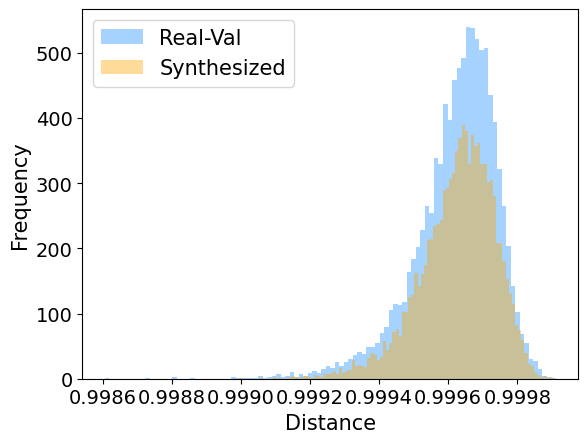

In [64]:
import seaborn as sns
from scipy import stats
bins = 100
aa = sns.distplot( 1-train_val_diff_sorted[:, 0]/128, color="dodgerblue", label="Real-Val", kde = False, bins = bins, fit_kws={'color':"dodgerblue"})
bb = sns.distplot(  1-train_synth_diff_sorted[:, 0]/128 , color="orange", label="Synthesized",  kde = False, bins = bins, fit_kws={'color':"orange"} )
#cc = sns.distplot(  train_train_diff_sorted[:, 1] , color="red", label="Train",  kde = False, bins = bins, fit_kws={'color':"orange"} )

#plt.figure()

#aa.set(ylim=(0, None)); bb.set(ylim=(0, None))
plt.xlabel('Distance', fontsize=15);plt.ylabel('Frequency', fontsize=15)
plt.legend( fontsize=15); #plt.ylim((0,34)); #plt.xlim((0,5))
plt.xticks(fontsize=14);plt.yticks(fontsize=14)


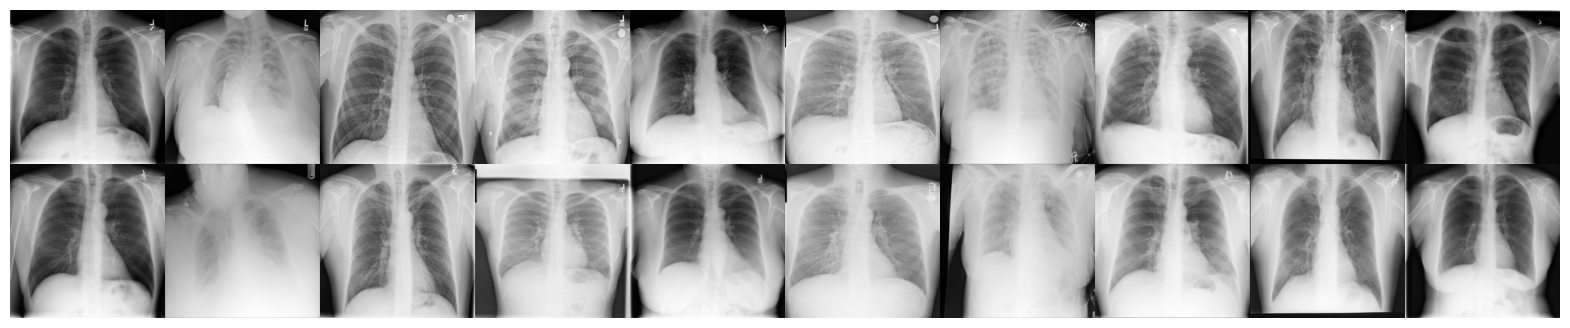

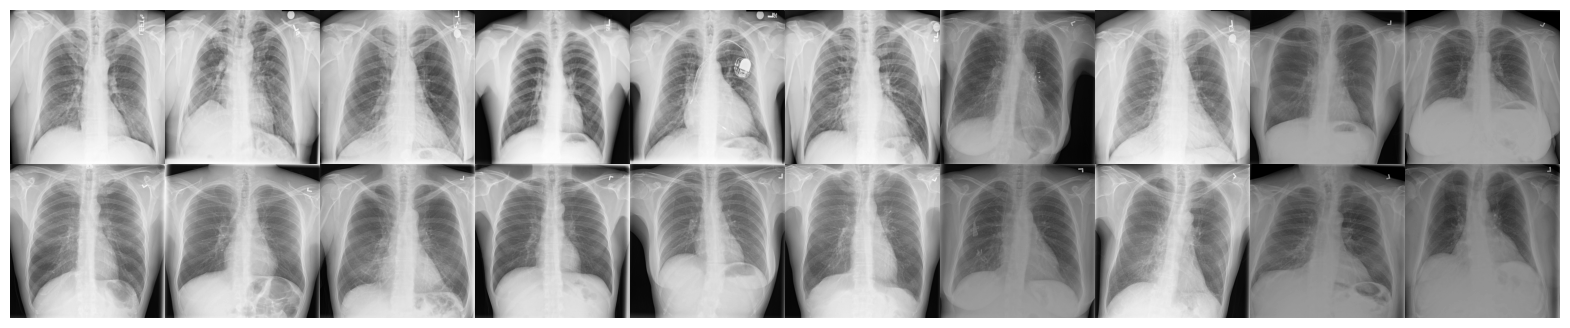

In [63]:
#Plot examples
sample_nos =  list(range(0,10))

fig, ax = plt.subplots(nrows= 2, ncols=len(sample_nos), gridspec_kw = {'wspace':0, 'hspace':0}, figsize = (len(sample_nos)*2,4))

fig2, ax2 = plt.subplots(nrows= 2, ncols=len(sample_nos), gridspec_kw = {'wspace':0, 'hspace':0}, figsize = (len(sample_nos)*2,4))
#fig.tight_layout()

for index, sample_no in enumerate(sample_nos):
    idx_train_synth =   train_synth_diff_sorted_idx2[sample_no]
    idx_synth=   train_synth_diff_sorted_idx[idx_train_synth, 0]


    idx_train_val =   train_val_diff_sorted_idx2[sample_no]
    idx_val =   train_val_diff_sorted_idx[idx_train_val, 0]


    # idx_train_train =   train_train_diff_sorted_idx2[sample_no]
    # idx_train =   train_train_diff_sorted_idx[idx_train_train, 1]

    
    ax[0,index ].imshow(train_data.__getitem__(idx_train_synth)["data"][0, :, :].numpy(), cmap="gray")
    ax[0,index ].axis('off');ax[0,index ].axis('tight') 
    ax[1, index].imshow(synth_data[idx_synth,0,:], cmap="gray")
    #ax[1, sample_no].imshow(train_data.__getitem__(idx_val)["data"][0, :, :].numpy(), cmap="gray")
    ax[1, index].axis('off');ax[1,index ].axis('tight') 

    ax2[0,index ].imshow(train_data.__getitem__(idx_train_val)["data"][0, :, :].numpy(), cmap="gray")
    ax2[0,index ].axis('off');ax2[0,index ].axis('tight') 
    ax2[1, index].imshow(val_data.__getitem__(idx_val)["data"][0, :, :].numpy(), cmap="gray")
    ax2[1, index].axis('off');ax2[1,index ].axis('tight') 



